In [7]:
import numpy as np
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

In [8]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

In [9]:
def generator_model(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    return model


In [10]:
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [11]:
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0002, decay=6e-8), 
                      metrics=['accuracy'])


In [12]:
generator = generator_model()

In [13]:
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=3e-8), 
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model


In [14]:
adversarial = adversarial_model()

In [15]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [16]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_dim])
        for epoch in range(train_epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # select a random half of images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
            
            # sample noise and generate a batch of new images
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generator.predict(noise)
            
            # train the discriminator (real classified as ones and generated as zeros)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # train the generator (wants discriminator to mistake images as real)
            y = np.ones([batch_size, 1])
            a_loss = adversarial.train_on_batch(noise, y)
            
            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))

In [17]:

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

0: [D loss: 0.693339, acc: 0.472656]  [A loss: 1.286165, acc: 0.000000]
1: [D loss: 0.580508, acc: 0.501953]  [A loss: 2.551824, acc: 0.000000]
2: [D loss: 0.327937, acc: 0.949219]  [A loss: 0.019955, acc: 1.000000]
3: [D loss: 1.462138, acc: 0.500000]  [A loss: 4.651537, acc: 0.000000]
4: [D loss: 0.321909, acc: 0.873047]  [A loss: 1.956855, acc: 0.000000]
5: [D loss: 0.180658, acc: 0.994141]  [A loss: 1.628862, acc: 0.000000]
6: [D loss: 0.150455, acc: 0.990234]  [A loss: 1.276644, acc: 0.031250]
7: [D loss: 0.125339, acc: 0.990234]  [A loss: 0.985269, acc: 0.226562]
8: [D loss: 0.108587, acc: 0.988281]  [A loss: 0.731272, acc: 0.523438]
9: [D loss: 0.092847, acc: 0.994141]  [A loss: 0.689439, acc: 0.539062]
10: [D loss: 0.088709, acc: 0.992188]  [A loss: 0.493826, acc: 0.800781]
11: [D loss: 0.082730, acc: 0.992188]  [A loss: 0.437852, acc: 0.843750]
12: [D loss: 0.061978, acc: 1.000000]  [A loss: 0.685356, acc: 0.636719]
13: [D loss: 0.057237, acc: 0.998047]  [A loss: 0.575390, acc

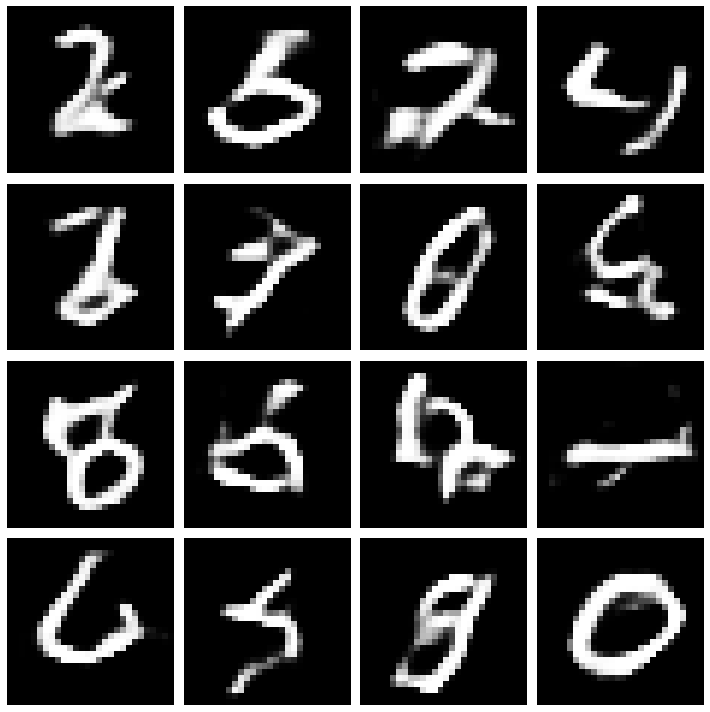

In [18]:
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100) 
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)